# Layers

Import the following:

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Apart from the basic nodes we encountered in the previous chapter, pytorch also provides a bunch of more complex *layers* located in torch.nn which encapsulate one or more nodes. Essentially you can think of such a layer as a subgraph of the computation graph.

## Linear Layer

One of the simplest and most important layers is the linear layer. This layer takes an input tensor $\vec{x}$ and produces an output tensor $\vec{y} = W\vec{x} + \vec{b}$.

Whenever you are looking at a node or a layer, it is very helpful to think about the dimensionalities of the tensors involved. Consider an example, where $\vec{x}$ has 3 features, i.e. $\vec{x} \in \mathbb{R}^{3}$. Let $\vec{y}$ be a probability distribution over $10$ classes, i.e. $\vec{y} \in \mathbb{R}^{5}$. Then we have $W \in \mathbb{R}^{5 \times 3}$ and $\vec{b} \in \mathbb{R}^{3}$ (otherwise the dimensions won't match).

This is how the above example would look in code:

In [7]:
d_in = 3
d_out = 5

x = torch.randn(d_in)

layer = nn.Linear(in_features=d_in, out_features=d_out)
y = layer(x)

Let's inspect the input vector:

In [8]:
x

tensor([ 0.5823,  0.7132, -0.3007])

In [9]:
x.size()

torch.Size([3])

Let us also inspect the output vector:

In [11]:
y

tensor([ 0.4404,  0.3218,  0.5207, -0.8105, -0.2359], grad_fn=<AddBackward0>)

Indeed we see that $W \in \mathbb{R}^{3 \times 5}$ and $\vec{b} \in \mathbb{R}^{5}$.

Put more generally if we have an input vector $\vec{x} \in \mathbb{R}^d$, the linear layer with parameters $W \in \mathbb{R}^{k \times d}$ and $\vec{b} \in \mathbb{R}^k$ will compute an output vector $\vec{y} \in \mathbb{R}^k$. Always keep thinking about tensor dimensionalities - this is the only way to *really* understand a node or layer computation. 

In [12]:
y.size()

torch.Size([5])

We can also manually verify the calculations:

In [14]:
layer.weight

Parameter containing:
tensor([[-0.5517,  0.2568,  0.0783],
        [ 0.2566, -0.1705,  0.1225],
        [-0.3060, -0.3898, -0.2540],
        [-0.2436, -0.0818,  0.2361],
        [-0.2218,  0.1268,  0.2490]], requires_grad=True)

In [17]:
layer.weight.shape

torch.Size([5, 3])

In [15]:
layer.bias

Parameter containing:
tensor([ 0.2336,  0.0629, -0.1942, -0.0534,  0.2297], requires_grad=True)

In [18]:
layer.bias.shape

torch.Size([5])

In [20]:
torch.matmul(layer.weight, x) + layer.bias

tensor([-0.9730,  0.6827, -0.5636, -0.4266, -0.2361], grad_fn=<AddBackward0>)

Note that we can pass a batch through the linear layer:

In [7]:
batch_dim = 4

X = torch.randn(batch_dim, d_in)
Y = layer(X)

In [8]:
Y.shape

torch.Size([4, 5])

## Activation Functions

Remember how we talk about *deep* learning all the time? That is because usually we have multiple layers following each other. The idea is that each layer learns progressively more complex features. For example the first layer might learn how individual words interact with each other, the second layer might look at word groups and the third layer might look at sentences. Note that this just an example - in practice the layers much more complicated features that can't be easily described (this is also one of their drawbacks). How would we go about constructing such a *deep* network?

Unfortunately, we cannot just put linear layers on top of each other. Consider two linear layers, which compute $\vec{h} = W\vec{x} + \vec{b}$ and $\vec{y} = V\vec{h} + \vec{c}$ respectively. Then we would have $\vec{y} = V\vec{h} + \vec{c} = V(W\vec{x} + \vec{b} + \vec{c}) = VW\vec{x} + V\vec{b} + \vec{c}$. Denote $U = VW$ and $\vec{d} = V\vec{b} + \vec{c}$ and we get $\vec{y} = U\vec{x} + \vec{c}$. Therefore the composition of two linear layers is again a linear layer! If you know your linear algebra, the above computation was a trivial exercise, but it reveals an important truth. We need to go beyond linearities to obtain models with rich capabilities.

To solve this problem, we introduce a nonlinear *activation function* between the layers to break the linearity. That is, the first layer computes $\vec{h} = f(W\vec{x} + \vec{b})$ (where $f$ works elementwise). The composition will no longer be a linear layer.

Now we need to actually define the activation function. We could use the sigmoid from chapter 2. However this function has a problem which we can see if we look at the graph of its derivative:

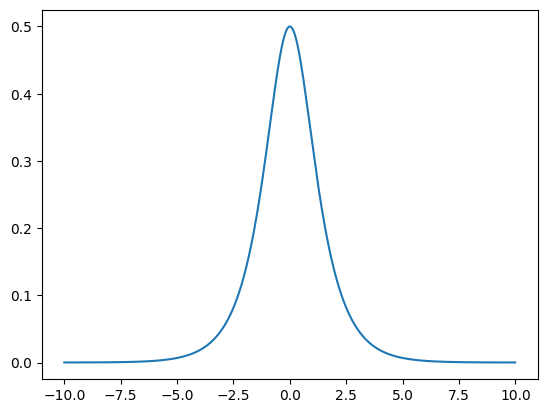

In [20]:
sigmoid_derivative_xs = np.arange(-10, 10, 0.01)
sigmoid_derivative_ys = np.exp(-sigmoid_derivative_xs) / (1 + np.exp(-sigmoid_derivative_xs) ** 2)
plt.plot(sigmoid_derivative_xs, sigmoid_derivative_ys)

The derivative of the sigmoid function is very close to $0$ outside of a relatively small input range. Why is this a problem? Let us say that during backpropagation the sigmoid node gets a derivative $\frac{\partial L}{\partial y}$. It will then backpropagate the derivative $\frac{\partial L}{\partial z} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z}$. But since $\frac{\partial y}{\partial z}$ will be approximately $0$, the derivative $\frac{\partial L}{\partial z}$ will be approximately $0$ as well. The derivative (and therefore the error signal) will be lost.

Just as a side note, the above explanation is one of the reasons why it so important to actually understand what backpropagation does on a technical level even though you will probably never need to implement it. It would be very hard to grasp why sigmoids are a bad idea for activation functions unless you have the technical understanding. This is not the last time we will encounter a problem that has its root in the way backpropagation works.

Executive summary - we need a different activation function that does not have such a small "good" range of inputs. A very simple way to address this is to simply take the identity function and cut off half the input range resulting in $\max(0, x)$:

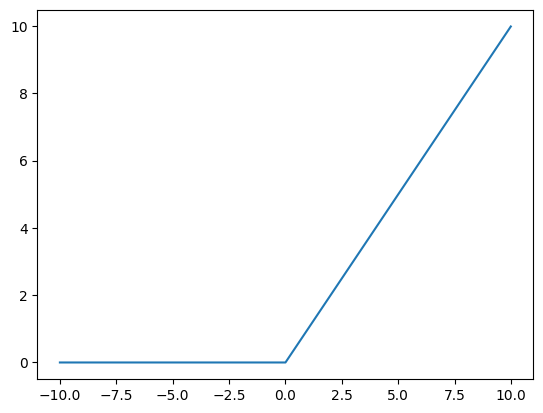

In [21]:
relu_xs = np.arange(-10, 10, 0.01)
relu_ys = np.maximum(0, relu_xs)
plt.plot(relu_xs, relu_ys)

The derivative is $0$ if $x < 0$ and $1$ if $x > 0$. We still lose half the input range, but the crucial point is that as long as $x > 0$ we are fine. Interestingly this function is not called the "most lazy activation possible" but has the fancy name **Rectified Linear Unit** (ReLU for short). Not only is this function very ~~lazy~~ simple, but it works extremely well in practice. So well in fact, that it is the default activation function people go with when creating neural networks. It is hard to overstate how much ReLU is used in deep learning nowadays.

## Dropout Layer

The dropout layer randomly zeroes some of the elements of the input tensor with probability `p`. This can be used to prevent overfitting:

In [22]:
dropout_layer = nn.Dropout(p=0.5)

x = torch.randn(d_in)
x

tensor([ 2.9677, -2.7410,  0.4559])

In [24]:
dropout_layer(x)

tensor([5.9355, -0.0000, 0.0000])

In [25]:
X = torch.randn(batch_dim, d_in)
X

tensor([[-0.6034, -1.3383, -1.0745],
        [ 0.0970,  1.1263,  1.3107],
        [ 0.5935,  1.6124, -0.3863],
        [-0.2381,  0.3930,  0.3202]])

In [26]:
dropout_layer(X)

tensor([[-0.0000, -0.0000, -2.1490],
        [ 0.1939,  2.2525,  2.6215],
        [ 1.1871,  0.0000, -0.0000],
        [-0.0000,  0.0000,  0.6404]])

## Layer Normalization

Layer normalization helps stabilize training:

In [27]:
X = torch.randn(batch_dim, d_in)
X

tensor([[ 0.0213, -0.9436, -1.0795],
        [-0.0361,  1.1067, -0.6574],
        [ 1.0809,  0.1795, -0.6091],
        [-1.0005, -1.0290,  1.0055]])

In [31]:
mean = X.mean(dim=-1, keepdim=True)
mean

tensor([[-0.6673],
        [ 0.1378],
        [ 0.2171],
        [-0.3414]])

In [32]:
var = X.var(dim=-1, keepdim=True)
var

tensor([[0.3603],
        [0.8007],
        [0.7151],
        [1.3607]])

In [33]:
X_norm = (X - mean) / torch.sqrt(var)

In [34]:
X_norm

tensor([[ 1.1473, -0.4605, -0.6868],
        [-0.1943,  1.0829, -0.8886],
        [ 1.0215, -0.0444, -0.9770],
        [-0.5651, -0.5895,  1.1546]])

In [35]:
X_norm.mean(dim=-1, keepdim=True)

tensor([[ 0.0000e+00],
        [-1.9868e-08],
        [-1.9868e-08],
        [ 0.0000e+00]])

In [37]:
X_norm.var(dim=-1, keepdim=True)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])

In [64]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift 

In [67]:
layer_norm = nn.LayerNorm(d_in)
layer_norm(X)

tensor([[ 1.4051, -0.5639, -0.8412],
        [-0.2380,  1.3263, -1.0883],
        [ 1.2510, -0.0544, -1.1966],
        [-0.6921, -0.7220,  1.4141]], grad_fn=<NativeLayerNormBackward0>)

In [68]:
layer_norm(X).var(dim=-1, unbiased=False, keepdim=True)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<VarBackward0>)